Step 1 – Load dataset & basic setup

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path

In [14]:
# File Path
BASE_DIR = Path().resolve().parents[1]

INPUT_PATH = BASE_DIR / "data" / "processed" / "final_arctic.csv"

In [ ]:
df_raw = pd.read_csv(INPUT_PATH)

# Create date column
df_raw["year"] = df_raw["year"].astype(int)
df_raw["month"] = df_raw["month"].astype(int)
df_raw["date"] = pd.to_datetime(dict(year=df_raw["year"], month=df_raw["month"], day=1))
df_raw = df_raw.sort_values("date")

TARGET = "sia_million_km2"

# Basic info
print("[INFO] Shape:", df_raw.shape)
print(df_raw.head())

[INFO] Shape: (543, 20)
   year  month  sia_million_km2  sie_million_km2    thick_m          cdir  \
0  1978     10         9.524144        10.153839        NaN  793575.44000   
1  1978     11        10.811478        11.506771        NaN   42043.16400   
2  1978     12        12.834232        13.668629        NaN     137.44655   
3  1979      1        14.615531        15.543609  3973.8833   10864.35900   
4  1979      2        15.492461        16.448393  3973.9478  352633.30000   

             uvb       slhf        sf        t2m        sst      istl1  \
0  110108.530000 -923622.06  0.000985  260.21402  272.12772  263.60452   
1    8703.622000 -821054.06  0.000860  253.88397  271.93120  259.63235   
2      67.879295 -621884.70  0.000541  249.05974  271.80540  255.64603   
3    2573.583700 -675217.70  0.000611  248.04901  271.73035  255.39026   
4   55168.465000 -591981.30  0.000524  243.43956  271.68857  251.93723   

       istl2      istl3      istl4        skt      ishf       tcc   

In [25]:
print("\n[NaN % by column]")
print((df_raw.isna().mean()*100).round(2))


[NaN % by column]
year               0.00
month              0.00
sia_million_km2    0.00
sie_million_km2    0.00
thick_m            2.76
cdir               0.00
uvb                0.00
slhf               0.00
sf                 0.00
t2m                0.00
sst                0.00
istl1              0.00
istl2              0.00
istl3              0.00
istl4              0.00
skt                0.00
ishf               0.00
tcc                0.00
tsn                0.00
date               0.00
dtype: float64


Step 2 – Light, in-memory fill for EDA plots

In [16]:
# Make a working copy for EDA (keeps df_raw untouched)
df_eda = df_raw.set_index("date").copy()

# Helper for month-aware fill
def monthaware_fill(s: pd.Series, months: pd.Series) -> pd.Series:
    clim = s.groupby(months).median()
    out = s.copy()
    out = out.fillna(months.map(clim))
    out = out.interpolate(method="time", limit_direction="both")
    if out.isna().any():
        out = out.fillna(out.median())
    return out

# Fill ice thickness
if "thick_m" in df_eda.columns:
    df_eda["thick_m"] = monthaware_fill(df_eda["thick_m"], df_eda["month"]).clip(lower=0)

# Fill other numeric cols for correlation/pairplots
num_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    if c not in {TARGET, "thick_m", "year", "month"}:
        s = df_eda[c]
        s = s.interpolate(method="time", limit_direction="both")
        if s.isna().any():
            s = s.fillna(df_eda["month"].map(s.groupby(df_eda["month"]).median()))
        if s.isna().any():
            s = s.fillna(s.median())
        df_eda[c] = s

df_eda = df_eda.reset_index()
print("\n[NaN % after fill in df_eda]")
print((df_eda.isna().mean()*100).round(2))


[NaN % after fill in df_eda]
date               0.0
year               0.0
month              0.0
sia_million_km2    0.0
sie_million_km2    0.0
thick_m            0.0
cdir               0.0
uvb                0.0
slhf               0.0
sf                 0.0
t2m                0.0
sst                0.0
istl1              0.0
istl2              0.0
istl3              0.0
istl4              0.0
skt                0.0
ishf               0.0
tcc                0.0
tsn                0.0
dtype: float64


In [17]:
# Summary stats for raw data
print("\n[SUMMARY STATS – Raw Data]")
print(df_raw.select_dtypes(include=[np.number]).describe().T)

# Summary stats for EDA copy
print("\n[SUMMARY STATS – EDA Copy]")
print(df_eda.select_dtypes(include=[np.number]).describe().T)


[SUMMARY STATS – Raw Data]
                 count          mean           std           min  \
year             543.0  2.000873e+03  1.307502e+01  1.978000e+03   
month            543.0  6.524862e+00  3.462347e+00  1.000000e+00   
sia_million_km2  543.0  1.035507e+01  3.363172e+00  6.422494e-01   
sie_million_km2  543.0  1.127242e+01  3.446321e+00  7.379435e-01   
thick_m          528.0  3.973422e+03  2.766642e-01  3.972820e+03   
cdir             543.0  8.274747e+06  9.111756e+06  7.220023e+01   
uvb              543.0  9.740743e+05  1.064230e+06  5.292351e+01   
slhf             543.0 -9.702590e+05  2.645493e+05 -1.819735e+06   
sf               543.0  6.695240e-04  1.756669e-04  1.276206e-04   
t2m              543.0  2.613284e+02  1.017783e+01  2.434396e+02   
sst              543.0  2.722446e+02  5.436512e-01  2.716886e+02   
istl1            543.0  2.639576e+02  6.483926e+00  2.519372e+02   
istl2            543.0  2.645845e+02  5.970753e+00  2.535338e+02   
istl3            543

Step 4 – Trend plots

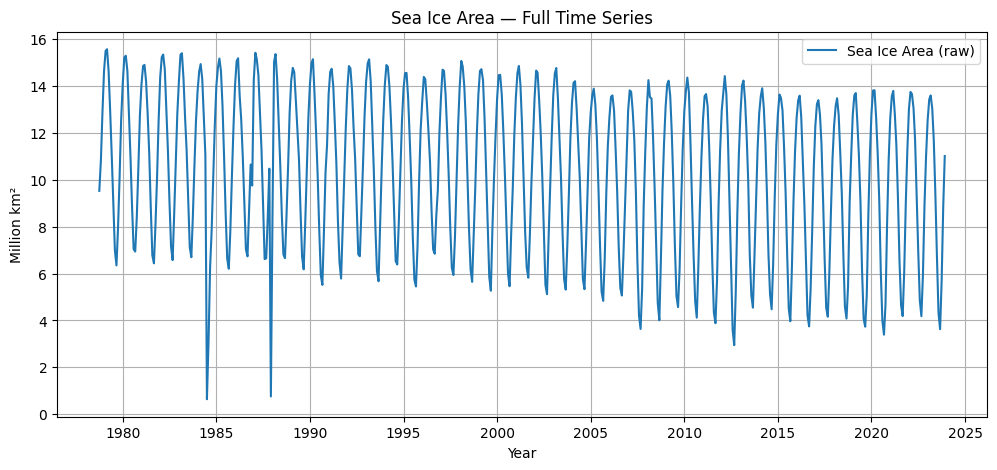

In [18]:
# Full time series (raw)
plt.figure(figsize=(12,5))
plt.plot(df_raw["date"], df_raw[TARGET], label="Sea Ice Area (raw)")
plt.title("Sea Ice Area — Full Time Series")
plt.xlabel("Year")
plt.ylabel("Million km²")
plt.grid(True)
plt.legend()
plt.show()

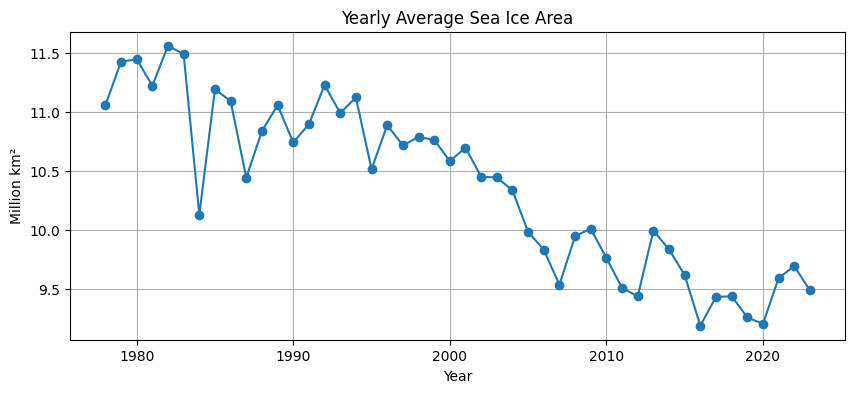

In [19]:
# Yearly average
yearly_mean = df_raw.groupby("year")[TARGET].mean()
plt.figure(figsize=(10,4))
plt.plot(yearly_mean.index, yearly_mean.values, marker='o')
plt.title("Yearly Average Sea Ice Area")
plt.xlabel("Year")
plt.ylabel("Million km²")
plt.grid(True)
plt.show()

Step 5 - Seasonality

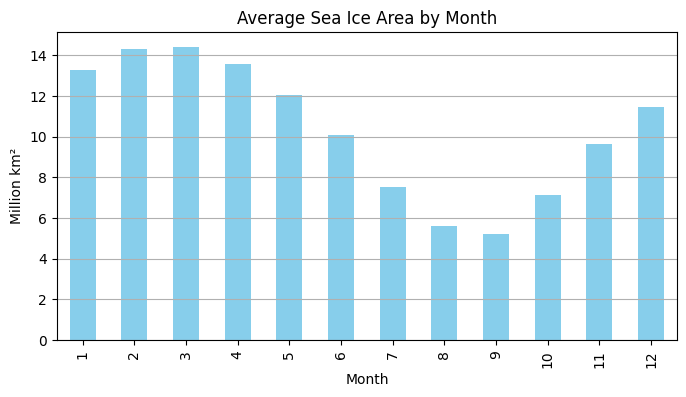

In [20]:
monthly_clim = df_raw.groupby("month")[TARGET].mean()

plt.figure(figsize=(8,4))
monthly_clim.plot(kind="bar", color="skyblue")
plt.title("Average Sea Ice Area by Month")
plt.xlabel("Month")
plt.ylabel("Million km²")
plt.grid(axis="y")
plt.show()

Step 6 -  Correlation Analysis

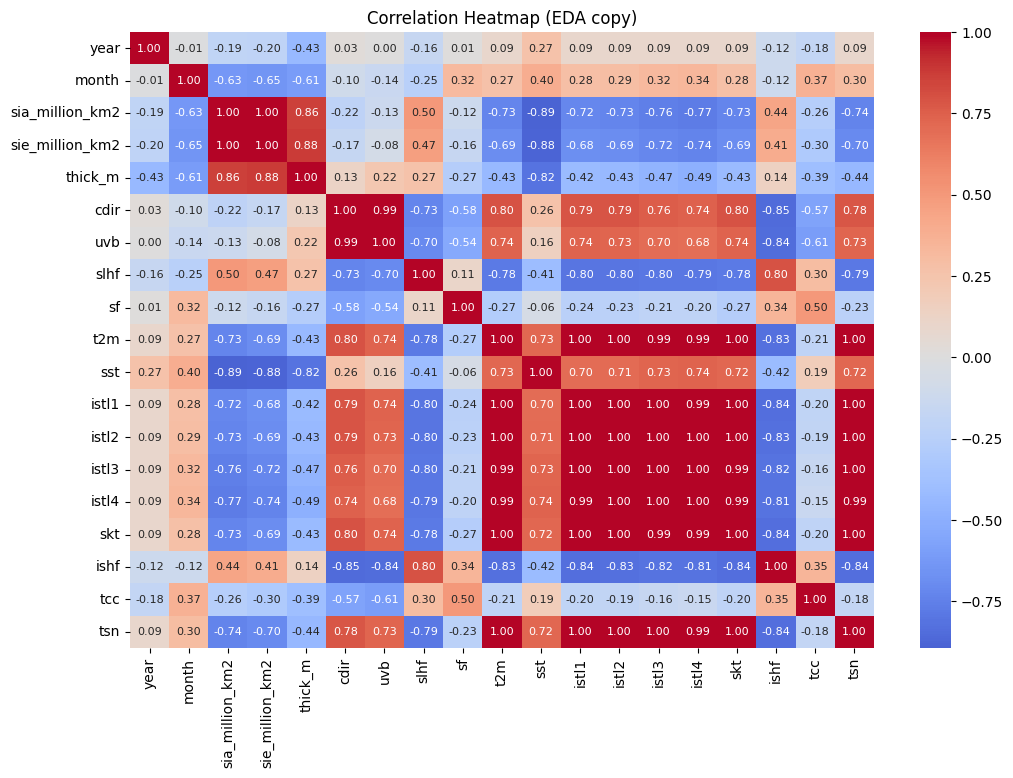

In [21]:
# Select only numeric columns for correlation
num_cols_eda = df_eda.select_dtypes(include=[np.number]).columns
corr = df_eda[num_cols_eda].corr()

plt.figure(figsize=(12,8))
sns.heatmap(
    corr,
    annot=True,        # <-- show values inside cells
    fmt=".2f",         # <-- 2 decimal places
    cmap="coolwarm",
    center=0,
    annot_kws={"size": 8}  # text size inside boxes
)
plt.title("Correlation Heatmap (EDA copy)")
plt.show()


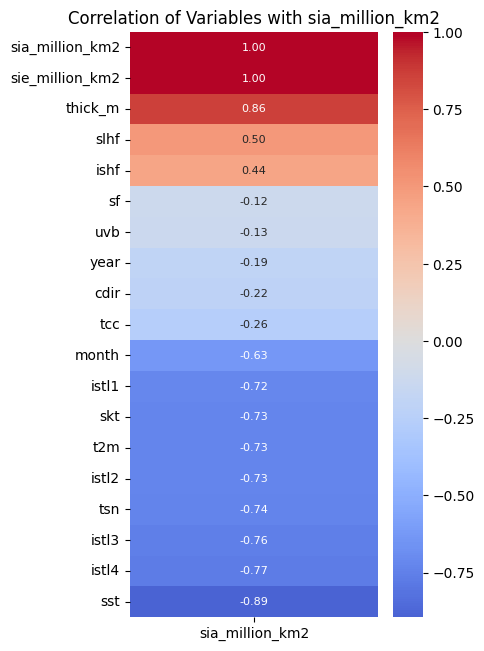

In [22]:
# --- 2) Target-only correlation heatmap ---
target_corr = corr[[TARGET]].sort_values(by=TARGET, ascending=False)

plt.figure(figsize=(4, len(target_corr) * 0.4))
sns.heatmap(
    target_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    annot_kws={"size": 8}
)
plt.title(f"Correlation of Variables with {TARGET}", fontsize=12)
plt.show()

Step 7 - Anomaly Detection


[Anomalies > 2σ]: 7
          date  sia_million_km2         z
69  1984-07-01         0.642249 -2.890657
70  1984-08-01         3.061180 -2.170753
110 1987-12-01         0.759885 -2.855647
406 2012-08-01         3.601057 -2.010078
407 2012-09-01         2.946150 -2.204987
503 2020-09-01         3.394357 -2.071595
539 2023-09-01         3.626610 -2.002474


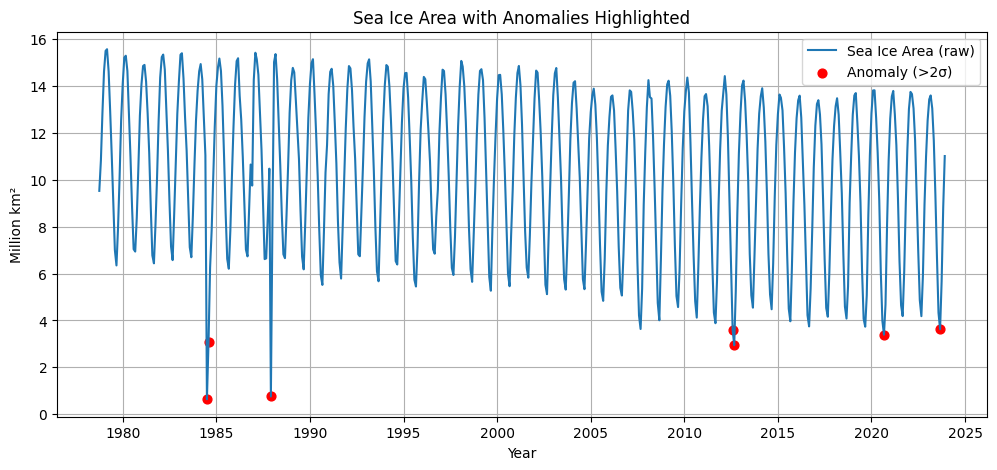

In [23]:
df_z = df_raw[["date", TARGET]].dropna().copy()
df_z["z"] = zscore(df_z[TARGET])
anoms = df_z[np.abs(df_z["z"]) > 2]

print(f"\n[Anomalies > 2σ]: {len(anoms)}")
print(anoms.head(10))

plt.figure(figsize=(12,5))
plt.plot(df_raw["date"], df_raw[TARGET], label="Sea Ice Area (raw)")
plt.scatter(anoms["date"], anoms[TARGET], label="Anomaly (>2σ)", s=40, color="red")
plt.title("Sea Ice Area with Anomalies Highlighted")
plt.xlabel("Year")
plt.ylabel("Million km²")
plt.legend()
plt.grid(True)
plt.show()

Step 8 – Pairplot for key variables

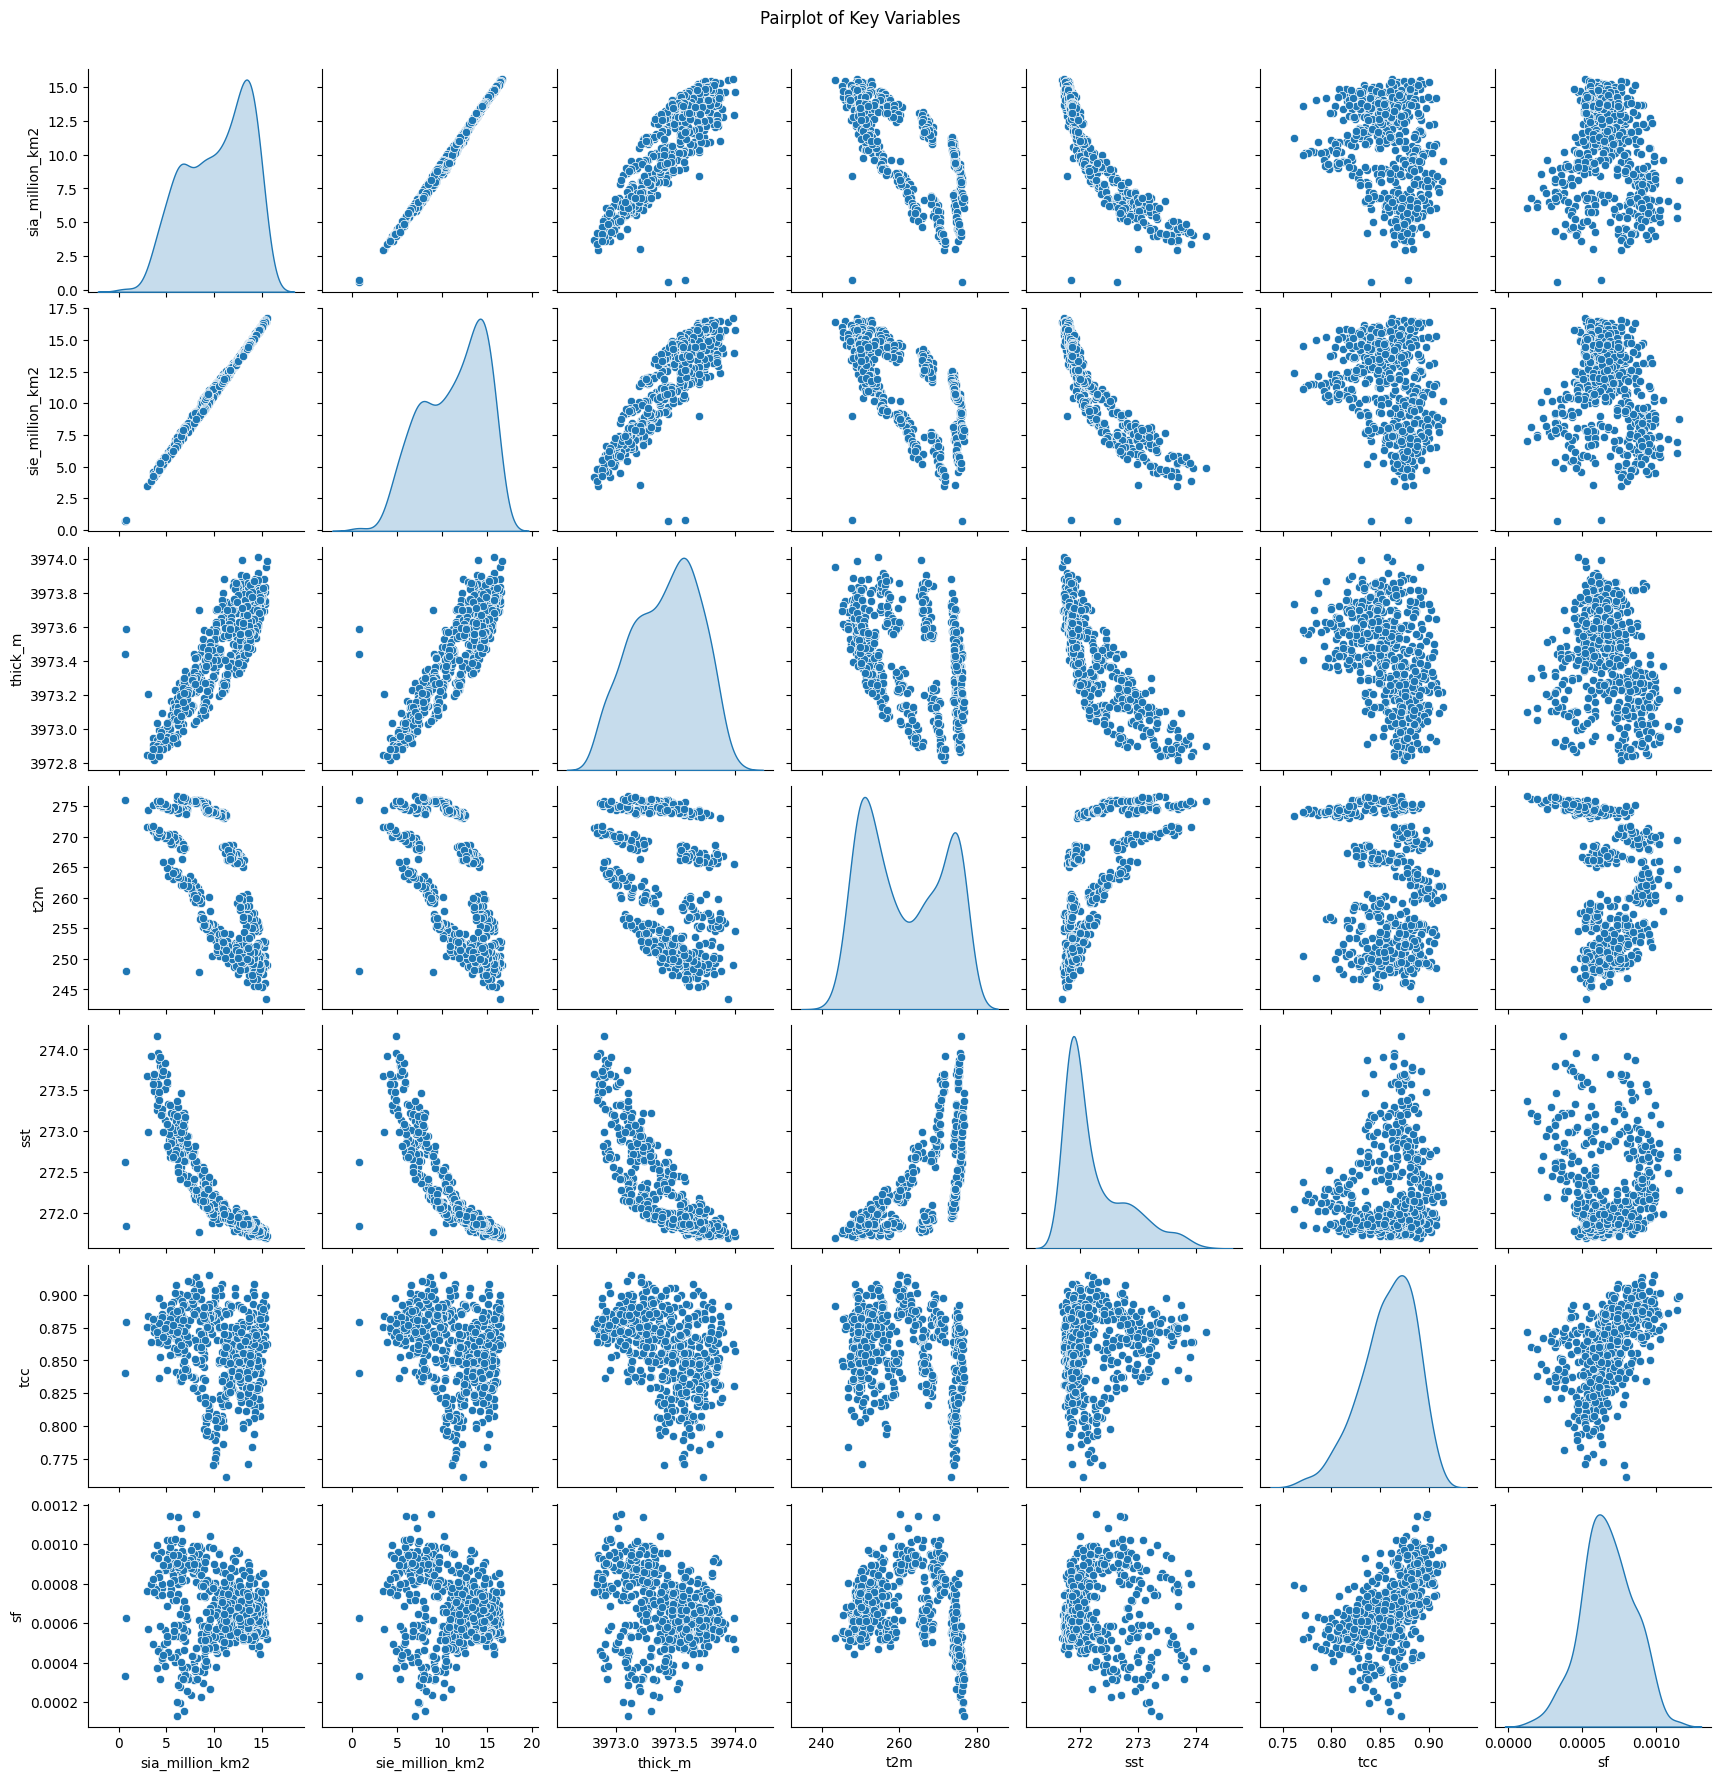

In [24]:
key_vars = [TARGET]
for c in ["sie_million_km2", "thick_m", "t2m", "sst", "tcc", "sf"]:
    if c in df_eda.columns:
        key_vars.append(c)

sns.pairplot(df_eda[key_vars], diag_kind="kde")
plt.suptitle("Pairplot of Key Variables", y=1.02)
plt.show()

# VIF Analysis

Cell A — Build predictor matrix & compute initial VIF table

In [28]:
# 1) choose numeric predictors only (drop target and obvious non-features)
drop_cols = {"year", "month", TARGET}
X = df_eda.select_dtypes(include=[np.number]).drop(columns=[c for c in drop_cols if c in df_eda.columns])

# 2) fill any residual NaNs (should be none after your EDA fills, but safe)
X = X.fillna(X.median(numeric_only=True))

# 3) (optional) standardize for numerical stability (doesn't change VIF values meaningfully)
X_std = (X - X.mean()) / X.std(ddof=0)

# 4) compute VIF table
vif_init = pd.DataFrame({
    "Variable": X_std.columns,
    "VIF": [variance_inflation_factor(X_std.values, i) for i in range(X_std.shape[1])]
}).sort_values("VIF", ascending=False).reset_index(drop=True)

vif_init

,Variable,VIF
0,istl2,2.097133e+06
1,istl3,1.343935e+06
2,istl1,8.588038e+05
3,istl4,3.982060e+05
4,skt,2.361743e+04
5,t2m,1.923878e+04
6,tsn,6.063199e+03
7,cdir,7.712339e+02
8,uvb,7.081777e+02
9,sst,2.409512e+01


Cell B — Iterative VIF reduction (drop until threshold)

In [29]:
def reduce_vif(X_in: pd.DataFrame, thresh: float = 10.0):
    """Iteratively drop the variable with the highest VIF > thresh."""
    variables = X_in.columns.tolist()
    dropped = []
    while True:
        # recompute on current set
        Xc = X_in[variables]
        Xc = (Xc - Xc.mean()) / Xc.std(ddof=0)  # standardize each round
        vifs = [variance_inflation_factor(Xc.values, i) for i in range(Xc.shape[1])]
        max_vif = float(np.max(vifs))
        if max_vif <= thresh:
            break
        max_var = variables[int(np.argmax(vifs))]
        dropped.append((max_var, max_vif))
        variables.remove(max_var)
    return variables, dropped

selected_vars, dropped_vars = reduce_vif(X, thresh=10.0)

print("[Dropped in order (var, VIF)]:")
for v, vval in dropped_vars:
    print(f"  - {v}: {vval:.2f}")

print("\n[Selected features after VIF reduction]:")
print(selected_vars)

# Final VIF table on the reduced set
X_final = (X[selected_vars] - X[selected_vars].mean()) / X[selected_vars].std(ddof=0)
vif_final = pd.DataFrame({
    "Variable": selected_vars,
    "VIF": [variance_inflation_factor(X_final.values, i) for i in range(X_final.shape[1])]
}).sort_values("VIF", ascending=False).reset_index(drop=True)

vif_final

[Dropped in order (var, VIF)]:
  - istl2: 2097133.03
  - istl3: 285798.85
  - skt: 22077.34
  - t2m: 3426.67
  - istl1: 937.80
  - tsn: 495.69
  - cdir: 182.78
  - uvb: 22.51
  - sie_million_km2: 11.35

[Selected features after VIF reduction]:
['thick_m', 'slhf', 'sf', 'sst', 'istl4', 'ishf', 'tcc']


,Variable,VIF
0,istl4,8.603139
1,sst,7.381016
2,thick_m,4.908158
3,ishf,4.632662
4,slhf,4.333595
5,sf,1.843972
6,tcc,1.815209


# PCA

Cell 1 — Imports (extra), constants, and safe helpers

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [39]:
# constants
TARGET = "sia_million_km2"
RANDOM_STATE = 42

Cell 2 — Feature matrix for modeling (lags + seasonal)

In [40]:
# Start from your EDA copy (already lightly filled for non-target vars)
df_m = df_eda.copy()

# 1) Autoregressive lags (use only past information)
for L in [1, 2, 3, 6, 12]:
    df_m[f"{TARGET}_lag{L}"] = df_m[TARGET].shift(L)

# 2) Seasonal features (month as cyclic)
df_m["month_sin"] = np.sin(2*np.pi*df_m["month"]/12)
df_m["month_cos"] = np.cos(2*np.pi*df_m["month"]/12)

# 3) Drop rows where lags are NaN (earliest rows)
df_m = df_m.dropna(subset=[f"{TARGET}_lag{L}" for L in [1,2,3,6,12]]).reset_index(drop=True)

print("[Modeling set] shape:", df_m.shape)
df_m.head()

[Modeling set] shape: (531, 27)


,date,year,month,sia_million_km2,sie_million_km2,thick_m,cdir,uvb,slhf,sf,...,ishf,tcc,tsn,sia_million_km2_lag1,sia_million_km2_lag2,sia_million_km2_lag3,sia_million_km2_lag6,sia_million_km2_lag12,month_sin,month_cos
0,1979-10-01,1979,10,7.913844,8.509899,3973.3520,815155.40000,111274.12500,-999975.75,0.000850,...,1.698796,0.895177,261.09604,6.345518,6.994931,9.006771,14.616976,9.524144,-8.660254e-01,0.500000
1,1979-11-01,1979,11,10.104662,10.853563,3973.4854,44246.57000,8902.36800,-848944.10,0.000782,...,4.570936,0.882787,253.28740,7.913844,6.345518,6.994931,12.925677,10.811478,-5.000000e-01,0.866025
2,1979-12-01,1979,12,12.523440,13.439073,3973.6180,154.05661,72.25263,-756819.20,0.000715,...,6.936772,0.891915,249.87509,10.104662,7.913844,6.345518,11.014788,12.834232,-2.449294e-16,1.000000
3,1980-01-01,1980,1,14.085177,15.167500,3973.7346,10765.62700,2512.27930,-783328.94,0.000636,...,7.653083,0.892710,249.53146,12.523440,10.104662,7.913844,9.006771,14.615531,5.000000e-01,0.866025
4,1980-02-01,1980,2,15.205339,16.334442,3973.8118,365278.00000,56165.20000,-640159.50,0.000693,...,7.644526,0.894545,250.05582,14.085177,12.523440,10.104662,6.994931,15.492461,8.660254e-01,0.500000


Cell 3 — Define variable groups for PCA

In [41]:
# variable groups (use only those that exist in your df_eda)
temp_vars = [c for c in ["t2m","sst","istl1","istl2","istl3","istl4","skt","tsn"] if c in df_m.columns]
rad_vars  = [c for c in ["cdir","uvb"] if c in df_m.columns]
flux_vars = [c for c in ["slhf","ishf"] if c in df_m.columns]
snow_cloud_vars = [c for c in ["sf","tcc"] if c in df_m.columns]

# From VIF step (already computed earlier):
# selected_vars = [...]   # <-- assumed from your previous cells

# Remove variables we will represent via PCA (so we don't duplicate info),
# and also remove any current-time variables you won't know at forecast time (like contemporaneous sie).
passthrough_vars = [v for v in selected_vars if v not in set(temp_vars + rad_vars)]
# optional: remove contemporaneous 'sie_million_km2' to avoid leakage at forecast time
passthrough_vars = [v for v in passthrough_vars if v != "sie_million_km2"]

# Add AR lags + seasonal features to passthrough
lag_cols = [f"{TARGET}_lag{L}" for L in [1,2,3,6,12]]
seasonal_cols = ["month_sin", "month_cos"]
passthrough_vars += lag_cols + seasonal_cols

# Make sure they exist
passthrough_vars = [c for c in passthrough_vars if c in df_m.columns]

print("Temp group for PCA:", temp_vars)
print("Rad group for PCA:", rad_vars)
print("Passthrough vars:", passthrough_vars)


Temp group for PCA: ['t2m', 'sst', 'istl1', 'istl2', 'istl3', 'istl4', 'skt', 'tsn']
Rad group for PCA: ['cdir', 'uvb']
Passthrough vars: ['thick_m', 'slhf', 'sf', 'ishf', 'tcc', 'sia_million_km2_lag1', 'sia_million_km2_lag2', 'sia_million_km2_lag3', 'sia_million_km2_lag6', 'sia_million_km2_lag12', 'month_sin', 'month_cos']


Cell 4 — Train/test split (time-aware)

In [56]:
# Time-based split: use last 60 months (~5 years) as test (tune as you like)
test_horizon = 120
train_df = df_m.iloc[:-test_horizon].copy()
test_df  = df_m.iloc[-test_horizon:].copy()

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET]
X_test  = test_df.drop(columns=[TARGET])
y_test  = test_df[TARGET]

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (411, 26) Test: (120, 26)


Cell 5 — ColumnTransformer with PCA groups

In [57]:
# PCA dimensionality: keep enough components to explain ~95% variance (auto-fit),
# but set an upper bound to keep it compact
pca_temp = PCA(n_components=min(4, len(temp_vars))) if len(temp_vars) > 0 else "drop"
pca_rad  = PCA(n_components=1) if len(rad_vars) > 0 else "drop"

transformers = []

if len(temp_vars) > 0:
    transformers.append(("temp_pca", Pipeline([("scaler", StandardScaler()), ("pca", pca_temp)]), temp_vars))
if len(rad_vars) > 0:
    transformers.append(("rad_pca", Pipeline([("scaler", StandardScaler()), ("pca", pca_rad)]), rad_vars))

if len(passthrough_vars) > 0:
    transformers.append(("passthrough_scaled", Pipeline([("scaler", StandardScaler())]), passthrough_vars))

preproc = ColumnTransformer(transformers=transformers, remainder="drop", verbose_feature_names_out=False)

# quick check
preproc

ColumnTransformer(transformers=[('temp_pca',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('pca', PCA(n_components=4))]),
                                 ['t2m', 'sst', 'istl1', 'istl2', 'istl3',
                                  'istl4', 'skt', 'tsn']),
                                ('rad_pca',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('pca', PCA(n_components=1))]),
                                 ['cdir', 'uvb']),
                                ('passthrough_scaled',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['thick_m', 'slhf', 'sf', 'ishf', 'tcc',
                                  'sia_million_km2_lag1',
                                  'sia_million_km2_lag2',
                                  'sia_million_km2_lag3',
                                  'sia_million_km2_lag6',
                                  'sia_million_km2_lag12', 'month_sin',
                                  'month_cos'])],
                  verbose_feature_names_out=False)

Cell 6 — Fit two models (Ridge & RandomForest) and evaluate

In [58]:
def evaluate_model(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    pred_tr = model.predict(Xtr)
    pred_te = model.predict(Xte)
    mae_tr = mean_absolute_error(ytr, pred_tr)
    rmse_tr = np.sqrt(mean_squared_error(ytr, pred_tr))
    mae_te = mean_absolute_error(yte, pred_te)
    rmse_te = np.sqrt(mean_squared_error(yte, pred_te))
    print(f"[{name}]  Train  MAE={mae_tr:.3f}  RMSE={rmse_tr:.3f} | Test  MAE={mae_te:.3f}  RMSE={rmse_te:.3f}")
    return model, pred_te

# Pipelines
ridge_pipe = Pipeline([
    ("pre", preproc),
    ("model", Ridge(alpha=1.0, random_state=RANDOM_STATE))
])

rf_pipe = Pipeline([
    ("pre", preproc),
    ("model", RandomForestRegressor(
        n_estimators=400, max_depth=None, min_samples_leaf=2, random_state=RANDOM_STATE, n_jobs=-1
    ))
])

# Fit + evaluate
ridge_model, ridge_pred = evaluate_model("Ridge+PCA", ridge_pipe, X_train, y_train, X_test, y_test)
rf_model, rf_pred = evaluate_model("RF+PCA", rf_pipe, X_train, y_train, X_test, y_test)

[Ridge+PCA]  Train  MAE=0.270  RMSE=0.738 | Test  MAE=0.241  RMSE=0.300
[RF+PCA]  Train  MAE=0.179  RMSE=0.482 | Test  MAE=0.359  RMSE=0.540


Cell 7 — Visualize predictions vs actual (test window)

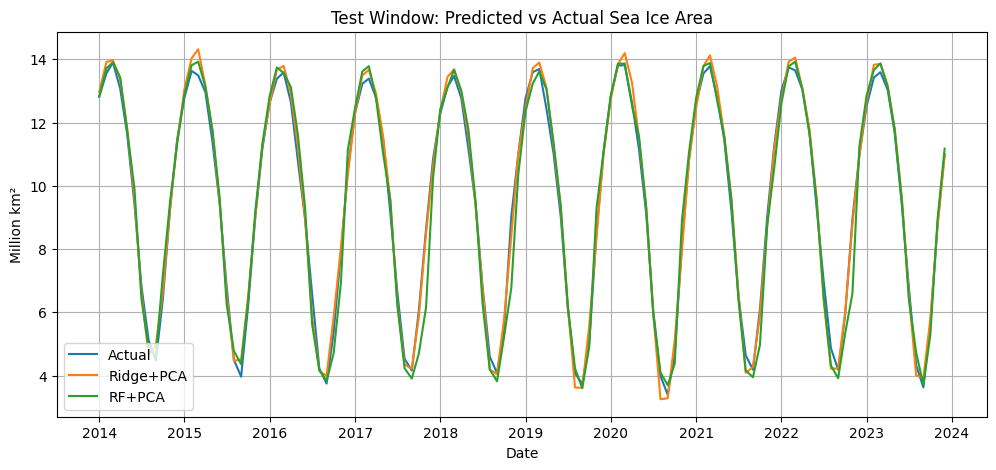

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test_df["date"], y_test.values, label="Actual")
plt.plot(test_df["date"], ridge_pred, label="Ridge+PCA")
plt.plot(test_df["date"], rf_pred, label="RF+PCA")
plt.title("Test Window: Predicted vs Actual Sea Ice Area")
plt.xlabel("Date")
plt.ylabel("Million km²")
plt.grid(True)
plt.legend()
plt.show()

Cell 8 — Forecast to “ice-free” (< 1 Mkm²) with an AR-seasonal model

[AR-seasonal (ElasticNet)]  Train  MAE=0.381  RMSE=0.821 | Test  MAE=0.380  RMSE=0.470


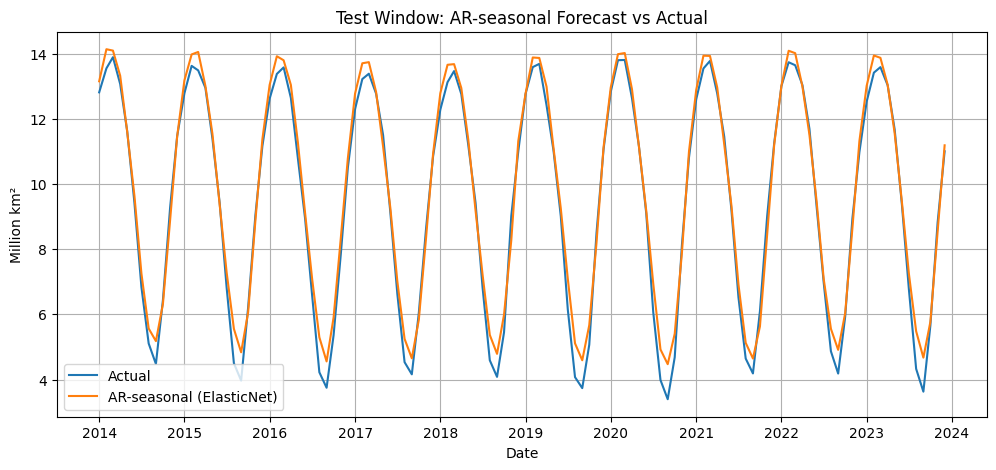

In [63]:
# Build a pure AR-seasonal dataset
df_ar = df_eda.copy()
for L in [1,2,3,6,12]:
    df_ar[f"{TARGET}_lag{L}"] = df_ar[TARGET].shift(L)
df_ar["month_sin"] = np.sin(2*np.pi*df_ar["month"]/12)
df_ar["month_cos"] = np.cos(2*np.pi*df_ar["month"]/12)
df_ar = df_ar.dropna(subset=[f"{TARGET}_lag{L}" for L in [1,2,3,6,12]]).reset_index(drop=True)

# Train/test split same as before for comparison
test_horizon = 120
train_ar = df_ar.iloc[:-test_horizon].copy()
test_ar  = df_ar.iloc[-test_horizon:].copy()

Xtr_ar = train_ar[[f"{TARGET}_lag{L}" for L in [1,2,3,6,12]] + ["month_sin","month_cos"]]
ytr_ar = train_ar[TARGET]
Xte_ar = test_ar[[f"{TARGET}_lag{L}" for L in [1,2,3,6,12]] + ["month_sin","month_cos"]]
yte_ar = test_ar[TARGET]

ar_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(alpha=0.01, l1_ratio=0.2, random_state=RANDOM_STATE))
])

_ , ar_pred = evaluate_model("AR-seasonal (ElasticNet)", ar_pipe, Xtr_ar, ytr_ar, Xte_ar, yte_ar)

plt.figure(figsize=(12,5))
plt.plot(test_ar["date"], yte_ar.values, label="Actual")
plt.plot(test_ar["date"], ar_pred, label="AR-seasonal (ElasticNet)")
plt.title("Test Window: AR-seasonal Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Million km²")
plt.grid(True)
plt.legend()
plt.show()

Cell 9 — Project forward monthly and estimate first “ice-free” date

In [66]:
# ============================
# Forecast to "ice-free" YEAR
# ============================
THRESHOLD = 1.0  # million km²

def roll_forecast_ar_seasonal(pipe, df_ar, target, max_years=120):
    """
    Roll forward monthly predictions using an already-fitted AR-seasonal model.
    Returns a DataFrame with future dates and predictions.
    """
    # start from the last known month
    cur = df_ar.copy()
    last_date = cur["date"].iloc[-1]

    def next_month(d):
        y = d.year + (1 if d.month == 12 else 0)
        m = 1 if d.month == 12 else d.month + 1
        return pd.Timestamp(year=y, month=m, day=1)

    # forecast up to max_years (adaptive outside this function if needed)
    months_to_forecast = max_years * 12
    out = []
    d = last_date
    for _ in range(months_to_forecast):
        d = next_month(d)
        row = {
            "date": d,
            "month": d.month,
            "month_sin": np.sin(2*np.pi*d.month/12),
            "month_cos": np.cos(2*np.pi*d.month/12),
        }
        # lags from the most recent values (observed or forecasted)
        for L in [1,2,3,6,12]:
            row[f"{target}_lag{L}"] = cur[target].iloc[-L]

        X_new = pd.DataFrame([row])[[f"{target}_lag{L}" for L in [1,2,3,6,12]] + ["month_sin","month_cos"]]
        y_hat = float(pipe.predict(X_new)[0])

        new_row = {**row, target: y_hat}
        cur = pd.concat([cur, pd.DataFrame([new_row])], ignore_index=True)
        out.append({"date": d, "month": d.month, "pred": y_hat})

    return pd.DataFrame(out)

def first_ice_free_year(fcst_df, threshold=THRESHOLD, criterion="any-month"):
    """
    criterion:
      - 'any-month': first calendar year when ANY month < threshold
      - 'september': first year when SEP (month=9) < threshold
    """
    if criterion == "any-month":
        hits = fcst_df[fcst_df["pred"] < threshold]
        if hits.empty:
            return None
        return int(hits["date"].min().year)

    if criterion == "september":
        sep = fcst_df[fcst_df["month"] == 9]
        hits = sep[sep["pred"] < threshold]
        if hits.empty:
            return None
        return int(hits["date"].min().year)

    raise ValueError("criterion must be 'any-month' or 'september'")

# ---- run adaptive forecast until we find a year or give up at a cap ----
cap_years = 5000  # absolute maximum to avoid infinite loops
step_years = 100  # extend by this many years per iteration
searched = 0
year_any = None
year_sep = None
fcst_df_all = None

while searched < cap_years and (year_any is None and year_sep is None):
    chunk_years = min(step_years, cap_years - searched)
    fcst_df = roll_forecast_ar_seasonal(ar_pipe, df_ar, TARGET, max_years=chunk_years)
    searched += chunk_years
    fcst_df_all = fcst_df if fcst_df_all is None else pd.concat([fcst_df_all, fcst_df], ignore_index=True)

    # try to find years with current accumulated forecast
    year_any = first_ice_free_year(fcst_df_all, THRESHOLD, "any-month")
    year_sep = first_ice_free_year(fcst_df_all, THRESHOLD, "september")

# ---- report ----
if year_any is not None:
    print(f"First forecasted ICE-FREE YEAR (ANY MONTH < {THRESHOLD} M km²): {year_any}")
else:
    print(f"No ice-free year (any-month) within {searched} forecast years.")

if year_sep is not None:
    print(f"First forecasted ICE-FREE YEAR (SEPTEMBER < {THRESHOLD} M km²): {year_sep}")
else:
    print(f"No ice-free September within {searched} forecast years.")

# also show how close we get within the horizon
min_row = fcst_df_all.loc[fcst_df_all['pred'].idxmin()]
print(f"Lowest predicted sea ice area within {searched} years: {min_row['pred']:.3f} M km² in {min_row['date'].date()}")

No ice-free year (any-month) within 5000 forecast years.
No ice-free September within 5000 forecast years.
Lowest predicted sea ice area within 5000 years: 5.107 M km² in 2024-09-01


Cell 10 — Plot the historical + AR-seasonal forecast

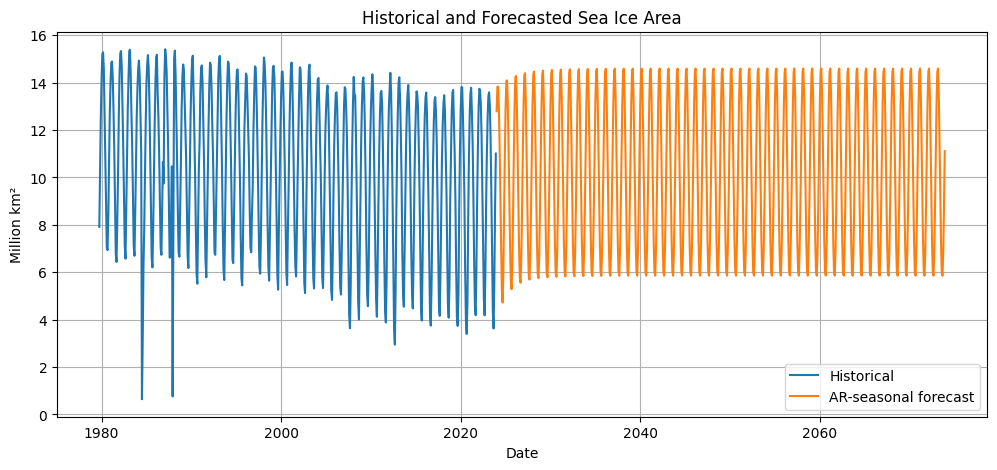

In [62]:
plt.figure(figsize=(12,5))
plt.plot(df_ar["date"], df_ar[TARGET], label="Historical")
plt.plot(fcst_df["date"], fcst_df["pred"], label="AR-seasonal forecast")
if pd.notnull(first_ice_free):
    plt.axvline(first_ice_free, linestyle="--", label="Ice-free threshold", alpha=0.7)
plt.title("Historical and Forecasted Sea Ice Area")
plt.xlabel("Date")
plt.ylabel("Million km²")
plt.grid(True)
plt.legend()
plt.show()
